In [1]:
#RUN THIS BEFORE USING
%reset
%matplotlib inline
import network_modules as nm
import graph_measures as gm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import networkx as nx
import collections
import scipy.signal as sig

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


C:\Users\rohit\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [25]:
slider1 = widgets.IntSlider(min=0, max=5000, step=50, value= 5, description = 'n')
slider2 = widgets.IntSlider(min=1, max=10, value=1, description = 'm')
slider3 = widgets.FloatSlider(min=0, max=10, value=1, description = 'a')
slider4 = widgets.FloatSlider(min=0, max=2*np.pi, value=0, description = 'b')
slider5 = widgets.FloatSlider(min=0, max=1, value=0, description = 'c')
slider6 = widgets.FloatSlider(min=0, max=10, value=1, description = 'K')
display(slider1, slider2, slider3, slider4, slider5,slider6)

In [26]:
n = slider1.value
m = slider2.value
print('n = ',n)
print('m = ',m)
G = nx.barabasi_albert_graph(n, m)

n =  5
m =  1


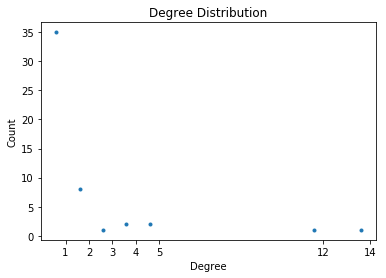

In [7]:
gm.degree_distribution(G)

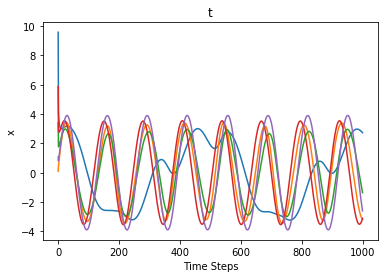

In [37]:
#Parameter Initialization

#first distribution for phase of limit cycle, second distribution for amplitude + standard deviation
states = nm.create_vec_states([(n,0,2*np.pi,'uniform'),(n,10,2,'normal')])
#convert polar to rectangular coordinates
phase = np.array([np.cos(states[:,0]) + 1j * np.sin(states[:,0])])
#create correct state matrix
x = np.array([amp*theta for amp,theta in zip(states[:,1],phase)]).T

#curry node function to be unique to each node: each node has a unique intrinsic frequency and amplitude
def currynode(w,a):
    def node(x):   #node function
        return np.array([x[0]*(1j * w + (a-abs(x[0])**2))]) # apply limit cycle term to keep in a circle
    return node

parameters = nm.create_vec_states([(n,10,2,'normal'),(n,10,2,'normal')])
# w : intrinsic freq. a : limit cycle amplitude
h = [currynode(w,a) for w,a in zip(states[:,0],states[:,1])]

def f(x,y): #coupling function

    return np.array([y[0]-x[0]])

M = np.identity(n) #Measurement Matrix
N = 0 #Noise Variance

oscillator = nm.nmodel(G,x,h,f,M,N,dt=.01)
oscillator.run(10)
nm.state_course(np.real(nm.reduce_state(0,oscillator.x)))

In [ ]:
def frange(start, stop, step):  
    i = start
    while i < stop:
        yield i
        i += step
        
@interact(off = (0.0,2*np.pi))
def f(off):
    x = np.array([np.cos(x) + 1j*np.sin(x) for x in frange(0,4*np.pi,.1)])
    y = np.array([np.cos(x + off) + 1j*np.sin(x + off) for x in frange(0,4*np.pi,.1)])
    plt.figure()
    plt.plot(np.array(x)[0])
    plt.plot(np.array(y)[0])
    plt.show()
    print(gm.correlation(x,y))
    

In [ ]:
#f, t, s = sig.spectrogram(signal, fs = 1000, window, nperseg, noverlap, nfft)
#f, Pxx = sig.welch(signal, fs = 1000, window, nperseg, noverlap, nfft)
#import pywt
#cA, cD = pywt.dwt([1, 2, 3, 4], 'db1') - Direct Wavelet Transform

In [ ]:
def create_random_matrix(n,p):
    A = np.zeros((n,n))
    for i in range(n):
        A[i,i] = 0
        for j in range(i+1,n):
            if np.random.random() < p:
                A[i,j] = 1
                A[j,i] = 1
    return A
n = 25
N = 10000
d = []
for m in range(N):
    A = create_random_matrix(n,.5)
    B = create_random_matrix(n,.5)
    d.append(sum(sum(A))/n**2)
plt.figure()
plt.hist(d,100)
plt.xlim(0,1)
plt.show()

In [ ]:
import module_main as mm
def offset_sinusoid(off,compare):
    x = np.array([np.cos(x) + 1j*np.sin(x) for x in frange(0,4*np.pi,.01)])
    y = np.array([np.cos(x + off) + 1j*np.sin(x + off) for x in frange(0,4*np.pi,.01)])
    #X = np.stack((x,y),0)
    return compare(np.real(x),np.real(y))
diff = []
for off in frange(0,2*np.pi,.1):
    diff.append(offset_sinusoid(off, lambda X,Y: np.mean(sig.coherence(X,Y)[1])))
plt.figure()
phase = [x for x in frange(0,2*np.pi,.1)] 
plt.plot(phase,diff)
plt.show()

In [ ]:
def DTF_func(X):
    X = np.real(X) 
    p = 2
    A = gm.MVAR_fit(X,p)
    P, freq = gm.DTF(A)
    return np.mean(np.mean(P))
def PDC_func(X):
    X = np.real(X) 
    p = 2
    A = gm.MVAR_fit(X,p)
    P, freq = gm.PDC(A)
    return np.mean(np.mean(P))

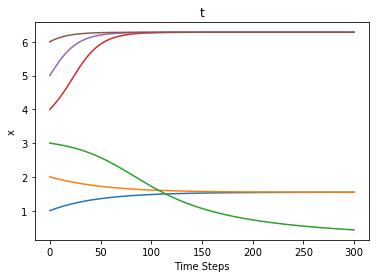

[[ 0.  1.  1.  1.  1.  1.]
 [ 1.  0.  1.  1.  1.  1.]
 [ 1.  1.  0.  1.  1.  1.]
 [ 1.  1.  1.  0.  1.  1.]
 [ 1.  1.  1.  1.  0.  1.]
 [ 1.  1.  1.  1.  1.  0.]]


In [2]:
coherence = lambda X,Y: max(sig.coherence(X,Y)[1])
nodes = [0,1,2,3,4,5]
Graphh = nx.Graph()
Graphh.add_nodes_from(nodes)
Graphh.add_edges_from([(0,1)])
def h(x):
    return -x*np.sin(x)
def f(x,y):
    return y
Matrix = np.identity(6)
Noise = 0
state = [[1],[2],[3],[4],[5],[6]]
tester = nm.nmodel(Graphh,state,h,f,Matrix,Noise,dt=.01)
tester.run(3)
nm.state_course(tester.x[:,0,:])
print(gm.cross_func(tester.x[:,0,:], gm.coherence))
#print(mm.DTF_func(tester.x[:,0,:]))
#print(gm.partial_method(tester.x[:,0,:],gm.r2))

In [ ]:
scale = 1
noisy_x = add_noise(oscillator.x,1)
#plt.plot(np.real(oscillator.x[0,0,:]))
plt.plot(np.real(noisy_x[0,0,:]))
plt.show()
add_noise = lambda X,dev: X + np.random.normal(0,dev,X.shape) + 1j*np.random.normal(0,dev,X.shape)
1j


In [ ]:
import pickle
with open('measure_normal' , 'rb') as pickle_data:
    measure_normal = np.array(pickle.load(pickle_data))
    x = measure_normal[0]
    print(x.shape)
    plt.figure()
    for mat in x:
        plt.imshow(mat, interpolation= "nearest")
        plt.show()

In [ ]:
with open('adj_data' , 'rb') as pickle_data:
    adj_data = np.array(pickle.load(pickle_data))
    with open('measure_normal' , 'rb') as pickle_data_2:
        measure_normal = np.array(pickle.load(pickle_data_2))
        x = measure_normal[0]
        plt.figure()
        for mat in x:
            plt.plot(adj_data.flatten(),mat.flatten(),'.')
            plt.show()
            

In [ ]:
import module_main as mm
import pickle

print('Running main')    

    #run n monte carlo simulations for time t get adjacency and time series data
time_data = []
adj_data = []
n = 1
for i in range(n):
    oscillator  = mm.generate_model()
    t = 20
    oscillator.run(t)
    time_data.append(oscillator.x)
    adj_data.append(nx.to_numpy_matrix(oscillator.G))
with open('time_data' ,'wb') as f:
    pickle.dump(time_data,f)
with open('adj_data', 'wb') as f:
    pickle.dump(adj_data,f)

print('Models Generated')
adj_data = []

In [ ]:
#generate connectivity matrixes for each measure for normal
with open('time_data' , 'rb') as pickle_data:
    trial = np.array(pickle.load(pickle_data))[0]
    noise = [.01,.1,1]
    trial_data = []
    for func in mm.list_of_measures:
            trial_data.append(func(trial[:,0,:]))
    adj_data.append(trial_data)
    for n in noise:
        trial_data = []
        noise_data = mm.add_noise(trial,n)
        for func in mm.list_of_measures:
            trial_data.append(func(noise_data[:,0,:]))
        adj_data.append(trial_data)
print(adj_data.shape)

In [ ]:
with open('time_data' , 'rb') as pickle_data:
    trial = np.array(pickle.load(pickle_data))[0]
    print(trial.shape)
    mm.add_noise(trial,.01)

In [ ]:
plt.figure()
with open('adj_data' , 'rb') as pickle_data:
    adj = np.array(pickle.load(pickle_data))[0]
    plt.imshow(adj, interpolation= "nearest")
    plt.show()
    i = 1
for mat in adj_data:
    print(i)
    i += 1
    plt.imshow(mat, interpolation= "nearest")
    plt.show()

In [ ]:
n_data = []
with open('adj_data' , 'rb') as pickle_data:
    adj = np.array(pickle.load(pickle_data))[0]
    n_data.append(gm.distance(adj,create_random_matrix(25,.5)))
    print(sim_data[0])
    plt.figure()
    for mat in adj_data[1]:
        plt.plot(adj.flatten(),mat.flatten(),'.')
        plt.show()
        thr = mm.gen_threshold(adj,mat)
        print(thr)
        arr = mm.thresh_array(mat,thr)
        print(gm.distance(adj,mat))
        n_data.append(gm.distance(adj,mat))
        plt.show()

In [ ]:
labels = range(len(sim_data))
ax = plt.bar(labels, sim_data)
plt.xticks(range(len(sim_data)), range(len(sim_data)))
plt.xlabel('Measures')
plt.ylabel('Similarity Constant')
plt.title('Accuracy of Measures')
plt.gca().set_ylim((0,1))
fig = plt.gcf()

C:\Users\rohit\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\rohit\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\Users\rohit\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\rohit\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

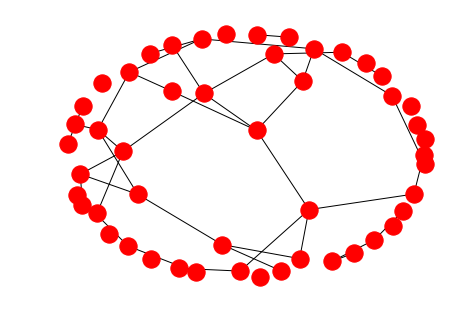

In [4]:
 def sparse_BA(n, lam, bias):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for node in G:
        n_edges = round(np.random.poisson(lam))
        if node != 0:
            if n_edges >= node:
                i_vec = [node] * node
                j_vec = range(node)
                G.add_edges_from([(i,j) for i,j in zip(i_vec,j_vec)])
            else:
                i_vec = [node] * n_edges
                j_vec = []
                degrees = np.array(list(nx.degree(G).values())) + bias
                degrees = (degrees)/sum(degrees)
                cs = np.cumsum(degrees)
                for i in range(node):
                    r = np.random.random()
                    larger = cs >= r
                    for j in range(len(larger)):
                        if larger[j]:
                            j_vec.append(j)
                            break
                G.add_edges_from([(i,j) for i,j in zip(i_vec,j_vec)])
                
    return G
G = sparse_BA(50,.7,10)
nx.draw(G)

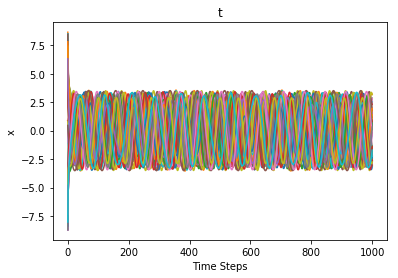

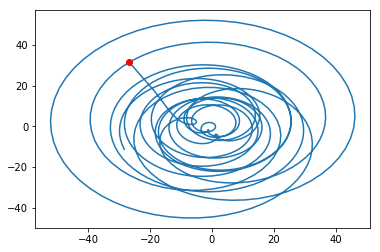

In [34]:
# generate Wilson Cowan model (each node has E/I states)
def generate_WC_model(G):
    